## Import

In [54]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 

sys.path.append('../../src/modules')
import eumf_data, eumf_pipeline, eumf_eval
from eumf_data import Labeled

from sklearn import preprocessing, pipeline, compose, ensemble, model_selection, metrics, impute, dummy

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
# migration rates
values = eumf_data.load_registrations_from_csv()

# google trends
trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = trends.columns.levels[0].tolist()

df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()


## Preprocessing

### Imputation

In [3]:
imputer = impute.KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(values.to_numpy())
values_imputed = pd.DataFrame(imputed, index=values.index, columns=values.columns)

panel = values_imputed.join(trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_3m["2010":"2010"]


value                                                                                                                                                                                                                                                       10                                                                                                                                     ...  59                                                                                                                                60                                                                                                                                                                                 
country        AT       BE        BG       CH       CY      CZ       DK       EE        ES       FI        FR        GB        GR       HR        HU       IE        IT       LT       LU       LV       NL        PL        PT        RO       SE       SI       SK     AT   BE   BG    CH    CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE     IT    LT   LU   LV     NL      PL    PT   ...  CY   CZ   DK   EE     ES    FI     FR      GB    GR   HR   HU   IE    IT    LT   LU   LV    NL    PL   PT   RO   SE   SI   SK     AT      BE      BG      CH    CY     CZ      DK    EE     ES    FI     FR      GB    GR   HR   HU     IE      IT    LT   LU   LV     NL      PL      PT      RO      SE    SI   SK 
date                                                                                                                                                                                                                                                                                                                                                                                                            ...                                                                                                                                                                                                                                                                                                                       
2010-03-31   862.667  216.333  2747.333  368.000  13.667  445.333  180.333   75.667   845.000  144.000  1012.000   692.667   790.000  704.333  1970.667   95.000  1976.000  430.333  148.333  560.667  726.667   7632.000  526.333  4353.000  202.333  144.333  568.667  0.0  0.0  0.0  2.238  0.0  0.0  0.0  0.0  18.429  0.0  19.619  15.762  0.0  0.0  0.0  0.0   8.762  0.0  0.0  0.0  16.667   5.190  0.0  ...  0.0  0.0  0.0  0.0  15.571  0.0  17.048   7.143  0.0  0.0  0.0  0.0  3.714  0.0  0.0  0.0  6.619  0.0  0.0  0.0  0.0  0.0  0.0  18.810   9.095  10.524  21.857  0.0   7.143   5.429  0.0  27.762  0.0  18.381  39.238  0.0  0.0  0.0   3.476   9.857  0.0  0.0  0.0   3.095  11.714  23.238   9.952  17.333  0.0  0.0
2010-06-30   811.667  195.667  3117.667  345.667  10.000  565.667  131.333   81.333   777.667  111.000   916.667   673.000   816.333  910.000  2459.000   98.000  1811.000  515.333  151.667  605.667  742.333  12445.667  511.667  7643.000  163.667  123.667  826.000  0.0  0.0  0.0  7.381  0.0  0.0  0.0  0.0  19.429  0.0   9.286  33.143  0.0  0.0  0.0  0.0   5.619  0.0  0.0  0.0  28.000   9.810  0.0  ...  0.0  0.0  0.0  0.0   8.095  0.0  12.857  29.048  0.0  0.0  0.0  0.0  1.381  0.0  0.0  0.0  2.333  0.0  0.0  0.0  0.0  0.0  0.0  15.238  13.143   0.000  27.286  0.0  11.238   6.571  0.0  27.714  0.0  19.190  50.524  0.0  0.0  0.0  25.143  27.857  0.0  0.0  0.0  31.714  18.095  12.238  10.476  25.143  0.0  0.0
2010-09-30  1168.667  323.000  3891.000  527.333  33.333  618.667  286.000  125.667  1556.333  237.667  1532.333  1209.000  1186.000  944.667  2970.333  173.667  2195.000  617.000  241.000  806.333  925.667  10549.333  645.000  7125.000  290.000  161.000  864.667  0.0  0.0  0.0  6.952  0.0  0.0  0.0  0.0  18.857  0.0  13.905  18.429  0.0  0.0  0.0  0.0   1.714  0.0  0.0  0.0   7.714  11.381  0.0  ...  0.0  0.0  0.0  0.0  23.381  0.0  

### Combine countries, join macroeconomic data

In [4]:
panel_comb = eumf_data.combine_countries(panel)
panel_comb_3m = eumf_data.combine_countries(panel_3m)
df_gdp_comb = eumf_data.combine_countries(df_gdp)
df_unempl_comb = eumf_data.combine_countries(df_unempl, average=True)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                                   11                                                                                                                                                           112                                                                              ...   value                                                                                             gdp                                                                                                                                                                   unempl                                                                                                              
country     AT  BE+NL+LU  BG     CH   CZ+SK  DK     ES      FR      GB   GR+CY  HR   HU   IE     IT   LV+LT+EE    PL    PT   RO   SE+FI   SI     AT   BE+NL+LU    BG      CH    CZ+SK     DK      ES      FR      GB    GR+CY    HR      HU      IE      IT   LV+LT+EE    PL      PT      RO    SE+FI   SI     AT   BE+NL+LU    BG      CH    CZ+SK      DK      ES      FR      GB    GR+CY   ...     HR        HU       IE        IT     LV+LT+EE     PL        PT        RO      SE+FI      SI       AT    BE+NL+LU    BG      CH     CZ+SK     DK       ES      FR      GB    GR+CY      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO    SE+FI      SI     AT   BE+NL+LU  BG   CH  CZ+SK  DK    ES   FR   GB  GR+CY    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI  SI 
date                                                                                                                                                                                                                                                                                                                                                                                           ...                                                                                                                                                                                                                                                                                                                                                                                               
2017-03-31  0.0  16.048   0.0  10.524   0.0  0.0  26.667  21.857  21.381   0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286  0.0  15.333  60.190    2.190  19.381  10.857  17.762  38.714  29.810  53.381  12.810  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571   8.762  0.0  66.238  178.952  42.238  30.952  127.048  55.571  33.143  63.333  47.286  29.619  ...  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  456.333  420.333  10080.0  42970.0  1510.0  18700.0  7620.0  12410.0  5950.0  8450.0  9080.0   9270.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  21370.0  4790.0   5.7    6.433   6.6  0.0  6.00  6.0  18.2  9.6  4.6  17.35  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3  7.75  7.4
2017-06-30  0.0  14.810   0.0   4.952   0.0  0.0  21.048  13.952  18.857   0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714  0.0  16.619  61.619   10.619  22.667   7.714  22.286  24.381  27.952  55.714   8.286  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  10.571  0.0  58.048  168.905  35.190  27.571   83.429  62.952  23.810  57.857  48.000  36.476  ...  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  367.000  365.000  10480.0  44540.0  1800.0  18770.0  8470.0  13040.0  6330.0  8560.0  8980.0  10000.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  22550.0  5260.0   5.4    5.867   6.2  0.0  5.75  5.9  17.3  9.6  4.4  16.70  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9  7.75  6.6
2017-09-30  0.0  16.095   0.0   4.905   0.0  0.0  12.429  21.048  16.048   0.0  0.0  0.0  0.0  11.810    0.0    10.762  0.0  0.0   9.667  0.0  19.143  68.952   16

## Experiments

### Multiclass variant

#### Common definitions

In [5]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

SCORING_MULTICLS = ["f1_micro", "f1_macro", "precision_macro", "recall_macro"]

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_stratified = model_selection.KFold(n_splits=8, shuffle=True, random_state=42)

#### Obtain optimum discretization

In [57]:
cv_scores, dummy_scores = {}, {}

for delta1 in [0.05, 0.1, 0.15, 0.2]:
    for delta2 in [0.0, 0.3, 0.4, 0.5]:

        if delta2 == 0.0:
            bins = [-np.inf, np.log(1.0 - delta1), np.log(1.0 + delta1), np.inf]
            classes = ["-", "=", "+"]
        else:
            bins = [
                -np.inf,
                np.log(1.0 - delta1),
                np.log(1.0 + delta1),
                np.log(1.0 + delta2),
                np.inf,
            ]
            classes = ["-", "=", "+", "++"]

        labeled = eumf_pipeline.prepare_data(
            panel_comb_3m_macro,
            columns=["19", "value", "gdp", "unempl"],
            lags=[1, 2, 3, 4, 5, 6],
            t_min=T_MIN,
            t_max=T_MAX,
        )
        transformed = eumf_pipeline.transform_data(labeled)
        train, test = eumf_pipeline.split_data(
            transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
        )
        train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
        train_cls, test_cls = eumf_pipeline.discretize_labels(
            train_stacked, test_stacked, bins=bins, classes=classes
        )

        tuner = eumf_pipeline.train_cls_model(train_cls)

        dummy_cls = dummy.DummyClassifier(strategy="stratified")

        cv_scores[(delta1, delta2)] = eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls,
            cv=cv_default,
            scoring=[
                "f1_micro",
                "f1_macro",
                "precision_micro",
                "precision_macro",
                "recall_micro",
                "recall_macro",
            ],
        )

        dummy_scores[(delta1, delta2)] = eumf_eval.score_cv(
            dummy_cls,
            train_cls,
            cv=cv_default,
            scoring=[
                "f1_micro",
                "f1_macro",
                "precision_micro",
                "precision_macro",
                "recall_micro",
                "recall_macro",
            ],

        )


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3

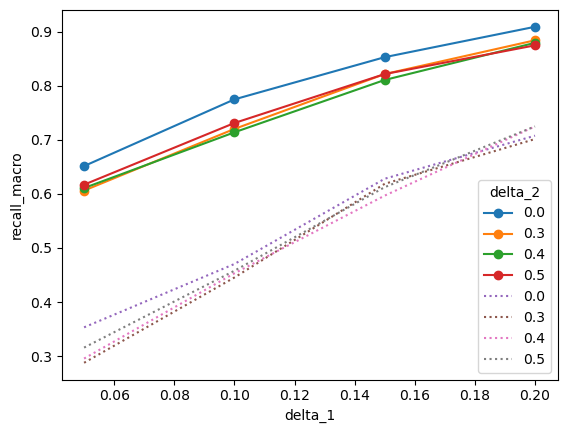

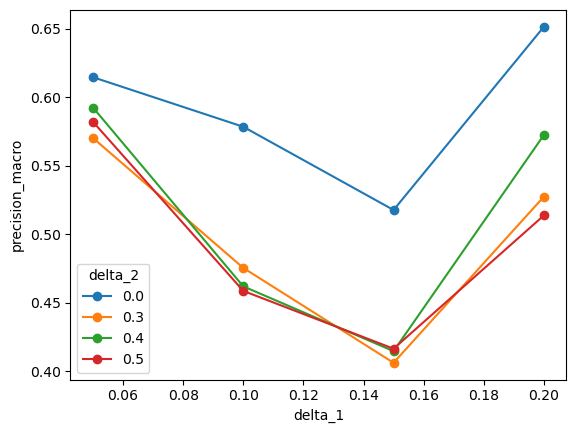

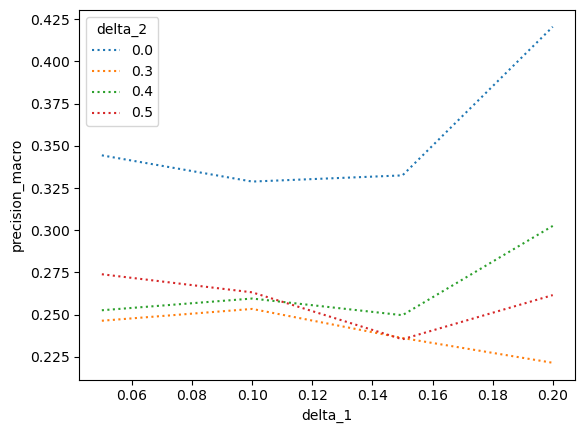

In [62]:
results = (
    pd.concat({k: v for k, v in cv_scores.items()})
    .rename_axis(index=["delta_1", "delta_2", "fold"])
    .groupby(level=[0, 1])
    .mean()
)
dummy_results = (
    pd.concat({k: v for k, v in dummy_scores.items()})
    .rename_axis(index=["delta_1", "delta_2", "fold"])
    .groupby(level=[0, 1])
    .mean()
)

results.unstack(level=1)["test_recall_micro"].plot(
    ylabel="recall_macro", ls="-", marker="o"
)
dummy_results.unstack(level=1)["test_recall_micro"].plot(
    ylabel="recall_macro", ls=":", ax=plt.gca()
)
plt.show()

results.unstack(level=1)["test_precision_macro"].plot(
    ylabel="precision_macro", ls="-", marker="o"
)
dummy_results.unstack(level=1)["test_precision_macro"].plot(
    ylabel="precision_macro", ls=":", ax=plt.gca()
)
plt.show()

# ["test_f1_macro"].plot()
# plt.show()


Despite these results, one should opt for lower thresholds. Otherwise, number of class members is too small and meaningless.

#### 4 Classes: "Best" configuration

In [45]:
"""training"""

bins = [-np.inf, np.log(0.95), np.log(1.05), np.log(1.4), np.inf]
classes = ["-", "=", "+", "++"]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "value", "gdp", "unempl"],
    lags=[1, 2, 3, 4, 5, 6],
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)
3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.303,0.034,0.021,7.233e-04,{},0.445,0.458,0.601,0.545,0.487,0.417,0.492,0.063,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


,mean,std,sem
fit_time,0.180,0.022,7.653e-03
score_time,0.015,0.001,4.787e-04
test_f1_micro,0.611,0.036,1.260e-02
test_f1_macro,0.504,0.044,1.559e-02
test_precision_macro,0.592,0.107,3.778e-02
test_recall_macro,0.507,0.047,1.666e-02


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.205,0.015,0.637,0.545,0.710,0.545
1,0.168,0.015,0.613,0.530,0.706,0.496
2,0.167,0.015,0.575,0.538,0.565,0.563
3,0.201,0.018,0.650,0.474,0.483,0.471
4,0.166,0.016,0.575,0.417,0.429,0.442
5,0.212,0.014,0.562,0.487,0.706,0.473
6,0.166,0.016,0.650,0.541,0.557,0.569
7,0.158,0.015,0.625,0.500,0.583,0.494


Holdout score:


f1_micro           0.613
f1_macro           0.590
precision_macro    0.697
recall_macro       0.551
dtype: float64

3

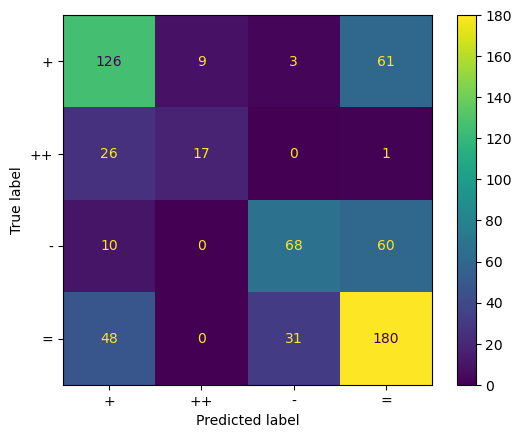

In [46]:
"""confusion matrix"""

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


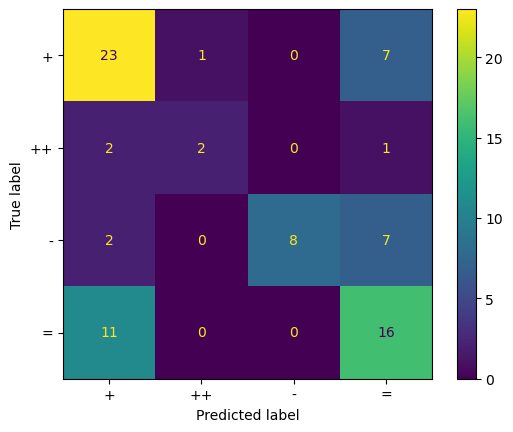

In [47]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()


#### 3 Classes: "Best" configuration

In [48]:
bins = [-np.inf, np.log(0.95), np.log(1.05), np.inf]
classes = ["-", "=", "+"]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "value", "gdp", "unempl"],
    lags=[1, 2, 3, 4, 5, 6],
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.346,0.055,0.041,0.014,{},0.712,0.492,0.665,0.523,0.526,0.399,0.553,0.105,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


,mean,std,sem
fit_time,0.199,0.017,6.151e-03
score_time,0.017,0.002,5.385e-04
test_f1_micro,0.652,0.107,3.783e-02
test_f1_macro,0.553,0.114,4.039e-02
test_precision_macro,0.615,0.137,4.826e-02
test_recall_macro,0.555,0.114,4.041e-02


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.201,0.018,0.863,0.739,0.732,0.748
1,0.185,0.017,0.738,0.513,0.771,0.469
2,0.208,0.017,0.625,0.598,0.714,0.554
3,0.167,0.019,0.650,0.630,0.649,0.618
4,0.220,0.016,0.613,0.599,0.609,0.641
5,0.206,0.019,0.537,0.386,0.362,0.417
6,0.190,0.018,0.650,0.536,0.596,0.569
7,0.213,0.014,0.537,0.423,0.484,0.427


Holdout score:


f1_micro           0.637
f1_macro           0.628
precision_macro    0.722
recall_macro       0.601
dtype: float64

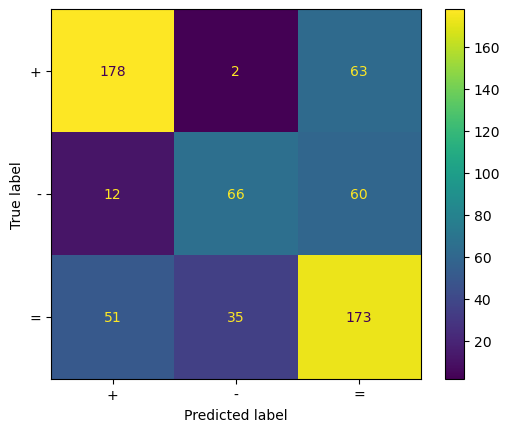

In [49]:
# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


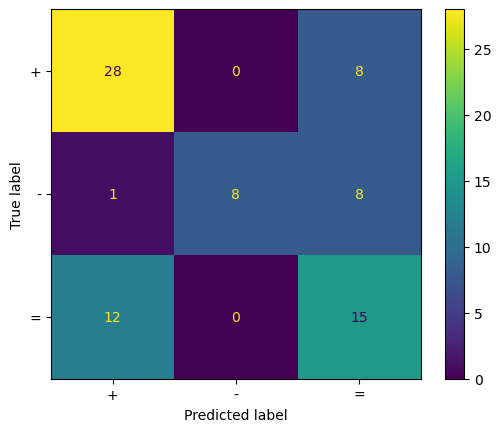

In [50]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()


#### 3 Classes: best configuration, but without own lags

In [51]:
bins = [-np.inf, np.log(0.95), np.log(1.05), np.inf]
classes = ["-", "=", "+"]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "gdp", "unempl"],
    lags=[1, 2, 3, 4, 5, 6],
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.527,0.048,0.066,0.009,{},0.662,0.382,0.634,0.434,0.426,0.366,0.484,0.119,1


Aggregate CV score:


,mean,std,sem
fit_time,0.273,0.043,0.015
score_time,0.032,0.010,0.003
test_f1_micro,0.600,0.122,0.043
test_f1_macro,0.478,0.110,0.039
test_precision_macro,0.521,0.114,0.040
test_recall_macro,0.487,0.104,0.037


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.293,0.029,0.825,0.631,0.643,0.623
1,0.240,0.024,0.713,0.446,0.434,0.460
2,0.224,0.020,0.537,0.434,0.639,0.410
3,0.233,0.026,0.662,0.649,0.656,0.644
4,0.262,0.034,0.525,0.498,0.538,0.513
5,0.272,0.032,0.500,0.394,0.413,0.400
6,0.335,0.053,0.562,0.435,0.474,0.488
7,0.330,0.034,0.475,0.339,0.371,0.354


Holdout score:


f1_micro           0.550
f1_macro           0.517
precision_macro    0.595
recall_macro       0.505
dtype: float64

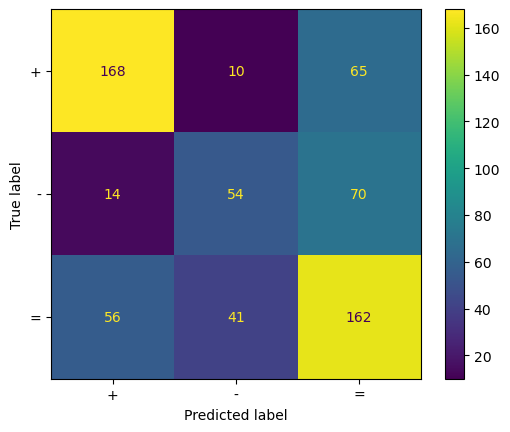

In [52]:
# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


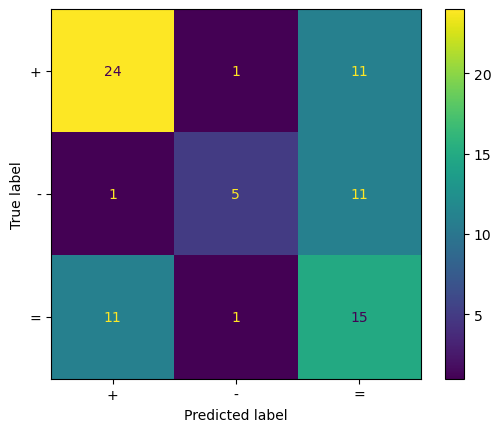

In [53]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()
